# 1 Discrete Fourier Transform and uncertainty propagation

*Before usage of this notebook, please download folder `Files_for_notebooks.zip` from this link https://github.com/harislulic/ZeMA-machine-learning-tutorials/releases/tag/v0.1.2
and store the files in the same folder which is location for this notebook.
It is also necessary to install pip in your environment and using this, package PyDynamic:*

pip install PyDynamic

*In order to see interactive diagrams, write:* 

pip install ipywidgets

jupyter nbextension enable --py widgetsnbextension   

## 1.1 Introduction 

Signals are represented mathematically as functions of one or more independent variables. The independent variable in the mathematical representation of a signal may be either continuous or discrete. Continuous time signals are defined along a continuum of times and thus are represented by a continuous independent variable. Continuous time signals are often referred to as analog signals. Discrete time signals are defined at discrete times and, the independent variable has discrete values; i.e. discrete time signals are represented as sequences of numbers. In practical setting, such sequences can often arise from periodic sampling of an analog signal. In this case, the numeric value of the *n*th number in the sequence is equal to the value of the analog signal $x_{a}(t)$, at time *nT*; i.e.:
$$x[n] =x_{a}(nT), {-\infty}<n<{\infty} $$

The quantity *T* is called the *sampling period* and its reciprocal is the *sampling frequency*.[8]

A discrete - time system is defined mathematically as transformation or operator that maps an input sequence with values *x[n]* into an output sequence with values *y[n]*. This can be denoted as:

$$y[n] =T[x[n]]$$

As with continuous time signals, discrete time signals may be represented in a number of different ways. For example, sinusoidal and complex exponential sequences play a particulary important role in representing discrete-time signals. This is because complex exponential sequences are eigenfunctions of linear time-invariant systems and the response to a sinusoidal input is sinusoidal with the same frequency as the input and with amplitude and phase determined by system.

Linear time invariant systems (more about in [8]) can be described by their impulse response, and the response to any time-distributed signal is described by convolving the signal with the impulse response. Convolution is a commutative and associative operation, but it is also quite computationally and conceptually expensive. For discrete signals, with the development of efficient Fast Fourier transform (FFT) algorithms, almost always, it is faster to implement a convolution operation in the frequency domain than in the time domain.

Properties of linear time invariant systems and their combinations are much better described and manipulated after Fourier transformation, for example:

Fourier transform of a signal tells you what frequencies are present in your signal and in what proportions.

*Have you ever noticed that each of your phone's number buttons sounds different when you press during a call and that it sounds the same for every phone model? That's because they're each composed of two different sinusoids which can be used to uniquely identify the button. When you use your phone to enter combinations to navigate a menu, the way that the other party knows what keys you pressed is by doing a Fourier transform of the input and looking at the frequencies present.*[9]

The magnitude square of the Fourier transform, $|X(f)|^2$ instantly tells us how much power the signal x(t) has at a particular frequency f.

### 1.1.1 Discrete Fourier Transform (DFT)

The Discrete Fourier Transform (DFT) is the equivalent of the continuous Fourier Transform for signals known only at instants separated by sample times (i.e.a ﬁnite sequence of data). The DFT corresponds to samples, equally spaced in frequency of the Fourier transform of the signal. In addition to its theoretical importance as a Fourier representation of sequnces, the DFT plays cetral role in the implementation of a variety of digital signal processing algorithms. This is because efficient algorithms exist for the computation of the DFT. These efficient algorithms are called *Fast Fourier transform (FFT)   algorithms* [8]. In particular for dynamic metrology, where the involved quantities have time varying values, the DFT is considered an essential tool. It is employed, for instance, to assess the frequency content of a measured time series, design suitable digital filters or carry out input estimation.[7]

The time taken to evaluate a DFT on a digital computer depends principally on the number of multiplications involved, since these are the slowest operations. With the DFT, this number is directly related to $N^2$ (matrix multiplication of a vector), where *N* is the length of the transform. For most problems, *N* is chosen to be at least 256 in order to get a reasonable approximation for the spectrum of the sequence under consideration – hence computational speed becomes a major consideration. Fast Fourier Transform (FFT) algorithms rely on the fact that the standard DFT involves a lot of redundant calculations and reduces their number.

## 1.2. The structure of tutorials

In the previous file, ZeMA testbed dataset was imported and visualized. It contains data from these 11 sensors available for estimation of remaining lifetime.
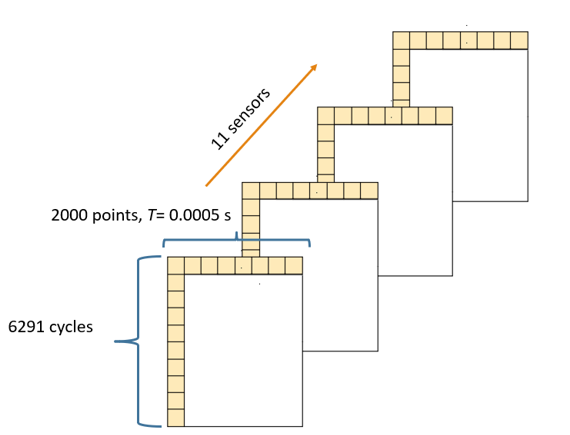

Machine learning methods thet are applied at ZeMA are separated into steps:

1) Feature Extraction

2) Feature Selection

3) Classification

4) Evaluation.

All of these steps were previously implemented in ZeMA-machine-learning-tutorials found on this link: https://github.com/harislulic/ZeMA-machine-learning-tutorials/tree/computation_without_uncertaintites .

This and the following notebooks are supplements of the previous tutorials, with focus on the uncertainty propagation in steps 1) and 2). Some parts from the previous tutorials are also presented here in order to show the comparison of results with and without uncertainties involved.

This notebook will explain the basics of (FFT) and principles of using PyDynamic software for the uncertainty propagation.
File [2_Features_extraction_and_selection.ipynb](2_Features_extraction_and_selection.ipynb) contains steps 1) and 2) supplemented by uncertainties. That file is very intensive and because of that, steps 1) and 2) can be found separately in  [2a_Features_extraction.ipynb](2a_Features_extraction.ipynb) and [2b_Features_selection.ipynb](2b_Features_selection.ipynb).


The workflow for these notebooks is:
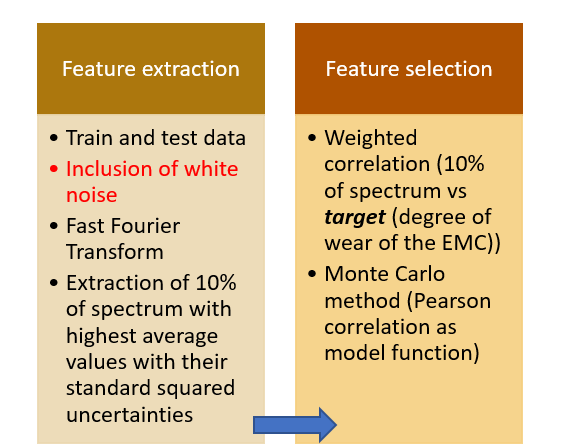

## 1.3 Fast Fourier transform (FFT)

A first idea for machine learning on the dataset from the previous notebook is to try to use fast Fourier transform to make useful features from time series. That's why we will first examine FFT on these time series.

Fourier showed that any periodic signal s(t) can be written as a sum of sine waves with various amplitudies, frequencies and phases [2]:

<img src="pictures/fft.png">

Results of this are amplitudes and phase shifts for frequency range from 0 to half the sampling frequency and it is covered by (N/2)+1 points where N is the size of the window i.e. number of samples. From Nyquist's theorem we know that the largest frequency component in the original signal must be half the sampling frequency. So, from a 2000 point FFT of signals sampled at 2000Hz we get 1001 unique spectral points covering the range 0 to 1000Hz.



In [1]:
import h5py                                                 #importing the h5 package
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import colors                                #ploting with colors
import scipy.fftpack                                         #fourier tranformation
from collections import OrderedDict
import matplotlib as mpl
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 20}
mpl.rcParams['figure.figsize'] = (20,10)
mpl.rc('font', **font)

### 1.3.1 Data import

In [3]:
url = 'https://zenodo.org/record/1326278/files/Sensor_data_2kHz.h5'

def get_filename(url):
    return url.split('/')[-1]

filename = get_filename(url)                    # Data filename.
f = h5py.File(filename, 'r')                    # Importing the h5 file. 
    
#print("Keys: %s" % f.keys())
a_group_key = list(f.keys())[0]

data = list(f[a_group_key])                       # Transforming data into list

sensorADC=[]                                      # Initialising a list "sensor" and
for i in range(len(data)):                        # Filling it with data from all sensors 
    sensorADC.append(pd.DataFrame(data[i]))

for i in range(len(data)):                             
    sensorADC[i]=sensorADC[i].iloc[:,:-1]         # Cuting the last cycle because it contains all zero elements.

print("""    
Input matrices have dimensions: %s, where %s represents number of measurements in time
and %s represents number of cycles.""" % (np.shape(sensorADC[0]),np.shape(sensorADC[0])[0],np.shape(sensorADC[0])[1]))

    
Input matrices have dimensions: (2000, 6291), where 2000 represents number of measurements in time
and 6291 represents number of cycles.


### 1.3.2 Converting into SI units 

In [4]:
offset=[0, 0, 0, 0, 0.00488591, 0.00488591, 0.00488591,  0.00488591, 1.36e-2, 1.5e-2, 1.09e-2]
gain=[5.36e-9, 5.36e-9, 5.36e-9, 5.36e-9, 3.29e-4, 3.29e-4, 3.29e-4, 3.29e-4, 8.76e-5, 8.68e-5, 8.65e-5]
b=[1, 1, 1, 1, 1, 1, 1, 1, 5.299641744, 5.299641744, 5.299641744]
k=[250, 9.81, 98.1, 98.1, 1.25, 100000, 30, 0.5, 2, 2, 2]
units=['[Pa]', '[mm/s^2]', '[mm/s^2]', '[mm/s^2]', '[kN]', '[Pa]', '[mm/s]', '[A]', '[A]', '[A]', '[A]']

pd.set_option('mode.chained_assignment', None)

sensor = list(sensorADC)
for i, df in enumerate(sensor):
    for row_label, row in df.iterrows():
        sensor[i].iloc[row_label,:]=((sensorADC[i].iloc[row_label,:]*gain[i])+offset[i])*b[i]*k[i]


###### If you have problems with previous step, you can skip conversion into SI units by running next cell.

In [ ]:
sensor=sensorADC

*One cycle of microphone sensor will be analysed with `FFT`.*

In [ ]:
# 0 represents sensor number (microphone)
# 3000 represents cycle number from microphone
df=sensor[0][3000]

Time axis is formed based on informations about data (`0_Data_Import_and_Visualisation.ipynb`). Sampling period is 1 second, and number of points is 2000 i.e. length of this time series.

After fast Fourier transform, this signal can be represented in the frequency domain. (**Amplitude-Frequency** plot) 

In [ ]:
time = 1                                                                   # sampling period 1 s
n_of_sampling_pts=2000                                                     # sampling points

x = np.true_divide(df.index, n_of_sampling_pts)                            # time values
freq = np.fft.rfftfreq(n_of_sampling_pts, float(time)/n_of_sampling_pts)   # frequency axis
amp = np.fft.rfft(df)   


In [ ]:
mpl.rcParams['figure.figsize'] = (20,10)
mpl.rc('font', **font)

plt.figure(figsize=(20,12))

plt.subplot(211)
plt.plot(x.values, df, label="Real values")
plt.ylabel("Microphone (Pa)")
plt.xlabel("Time (s)")

plt.subplot(212)
plt.plot(freq,np.abs(amp))
plt.xlabel("Frequency (Hz)")  
plt.ylabel("Amplitude (Pa)")  

Because of idea to use 10% of these amplitudes for machine learning workflow, which should be enough to reconstruct the signal and make prediction, reconstruction using 10% highest amplitudes will be shown here.

Amplitudes are sorted by their absolute values from highest to lowest.

In [ ]:
coeffs = dict(zip(freq, amp))

# take top N % of coefficients  !!!! This can be changed !!!!
N=10

# taking top N % aplitudes and sorting them by value, t[1] means sorting by second column i.e. by values of dictionary
out = OrderedDict(sorted(coeffs.items(), key=lambda t: abs(t[1]), reverse=True)[:round((N/100.0)*len(freq))])  

sorted_amp=list(out.values())       #transforming sorted dictionary to the list

Keeping only 10% choosen frequencies. 

In [ ]:
treeshold_apsolute_amplitude=abs(sorted_amp[-1])      #choosing the treeshold amplitude

for key, value in coeffs.items():
        if abs(value) <= treeshold_apsolute_amplitude:
             coeffs[key]=0+0j
                
top_10=list(coeffs.values())

Another plot in frequency domain, will show which frequencies out of full spectrum are selected and why.

In [ ]:
plt.plot(freq,np.abs(amp),zorder=1, linewidth=4,label='Full spectrum') 
plt.ylabel("Amplitude (Pa)") 

plt.plot(np.abs(top_10),zorder=2, label='10% frequencies')
plt.xlabel("Frequency (Hz)")
plt.legend()

Next plot shows sorted amplitudes, but without frequency labels.  

In [ ]:
plt.stem(np.abs(sorted_amp), markerfmt=' ', use_line_collection=True)
plt.ylabel("Amplitude (Pa)") 

Reconstructing using inverse fast Fourier transform will give similar sensor signal, and that is why these frequencies and amplitudes are very good features for comparing different cycles.

In [ ]:
inverse_fft = np.fft.irfft(top_10)

plt.plot(x.values, df, label="Real values")
plt.ylabel("Microphone (Pa)")
plt.xlabel("Time (s)")
plt.plot(x.values,inverse_fft, label="Reconstructed values")
plt.xlim(0,1)
plt.legend()


This procedure can be done for every sensor and every cycle of each sensor.

## 1.4 PyDynamic for the uncertainty propagation

In order to perform uncertainty evaluation, the PyDynamic software is used. The software is based on Discrete Fourier Transform (DFT) with some FFT algorithm.
The time domain signal is *x(t).* A white noise will be added to this signal:

$$x_{n}(t) = x(t)+\epsilon$$

White noise has normal distribution ${\mathcal {N}}(0 ,\sigma ^{2})$ and standard deviation that can be specified by user. 

The time domain signal that will be analyzed is $x_{n}$ with associated uncertainty  $u_{x}$ as squared standard deviation representing white-noise variance ($\sigma^2$).
White noise is a signal whose spectrum has equal power within any equal interval of frequencies.

The result of the DFT is the vector X of real and imaginary parts of the DFT applied to  $x_{n}$ and the associated uncertainty UX ( covariance matrix associated with  or as a variance in the case of white noise.) When only white noise is considered, all off-diagonal elements of UX are equal to zero. [5] 

Sampling period is 1 second, and number of points is 2000 i.e. length of this time series.

*One cycle of microphone sensor will be analysed with `DFT`.*

In [ ]:
from PyDynamic import __version__ as version
version

In [ ]:
sigma=float(input("Assume standard deviation:"))                           #signal noise standard deviation
sensor_num = int(input("Enter the number of sensor (0-11):"))
cycle=int(input("Enter the cycle(0-6291):"))

In [ ]:
#if you did not convert the signal to SI units, convert here
offset=[0, 0, 0, 0, 0.00488591, 0.00488591, 0.00488591,  0.00488591, 1.36e-2, 1.5e-2, 1.09e-2]
gain=[5.36e-9, 5.36e-9, 5.36e-9, 5.36e-9, 3.29e-4, 3.29e-4, 3.29e-4, 3.29e-4, 8.76e-5, 8.68e-5, 8.65e-5]
b=[1, 1, 1, 1, 1, 1, 1, 1, 5.299641744, 5.299641744, 5.299641744]
k=[250, 1, 10, 10, 1.25, 1, 30, 0.5, 2, 2, 2]
units=['[Pa]', '[g]', '[g]', '[g]', '[kN]', '[bar]', '[mm/s]', '[A]', '[A]', '[A]', '[A]']

sensor[sensor_num][:][cycle]=((sensor[sensor_num][:][cycle]*gain[sensor_num])+offset[sensor_num])*b[sensor_num]*k[sensor_num]

In [ ]:
#adding white noise to the signal
sensor[sensor_num][:][cycle]=sensor[sensor_num][:][cycle]+np.random.randn(sensor[sensor_num].shape[0])*sigma

In [ ]:
import PyDynamic
ux=sigma**2                                                                
time = 1                                                                   # sampling period 1 s
n_of_sampling_pts=2000                                                     # sampling points
time_steps=np.arange(0, time, float(time)/n_of_sampling_pts) 

# timesteps for the period (0 - 1) s
X,UX=PyDynamic.uncertainty.propagate_DFT.GUM_DFT(sensor[sensor_num][:][cycle],ux)
print("Vector X has dimensions:",X.shape)                                         # vector of real and imaginary parts
print("Vector UX has dimensions:",UX.shape)                                        # vector/covariance matrix of uncertainites
freq=PyDynamic.uncertainty.propagate_DFT.GUM_DFTfreq(2000, float(time)/n_of_sampling_pts)
# frequency axis (array of length N//2 + 1 containing the sample frequencies)

First plot represents time domain signal values. The second and third plot represent real and imaginary parts of the vector X, with their associated uncertainty. 
*Note: au - arbitrary unit*

In [ ]:
mpl.rcParams['figure.figsize'] = (20,10)
mpl.rc('font', **font)

plt.figure(figsize=(20,12))
plt.plot(time_steps, sensor[sensor_num][:][cycle])
plt.xlabel("time (s)")
plt.ylabel("Microphone (Pa)")
plt.figure(figsize=(20,12))
plt.subplot(211)
plt.errorbar(freq, X[:len(freq)], xerr=np.sqrt(UX[:len(freq)]))
plt.ylabel("real parts (au) ")
plt.xticks([])
plt.subplot(212)
plt.errorbar(freq, X[len(freq):], xerr=np.sqrt(UX[len(freq):]))
plt.ylabel("imaginary parts (au)")
plt.xlabel("frequency / Hz")

### 1.4.1 Transformation from real and imaginary parts to amplitudes and phases

DFT gives complex values obtained from real and imaginary parts as results. Nevertheless, it is possible to calculate amplitudes and phases instead. 

Amplitudes and phases are calculated on the basis of vector X  and covariance matrix of uncertainties, UAP on the basis of  uncertainties UX. The shape of matrix of uncertainties, UAP is (2M,2M), where *M* corresponds to the number of (*N*/2)+1 points (*N* - number of sampling points). The shape of matrices of amplitudes and phases, respectively A, P is (M,M).

*Note: When amplitudes are small relative to the uncertainty associated with real and imaginary parts , the GUM uncertainty propagation becomes unreliable and a Monte Carlo method is recommended instead. Consequently, GUM2DFT does raise a warning to the user and recommends using a Monte Carlo method instead whenever an element of  is below a pre-defined threshold. The default threshold in GUM2DFT is 1.0, but may be adjusted for specific applications.[7]*



In [ ]:
A,P,UAP=PyDynamic.uncertainty.propagate_DFT.DFT2AmpPhase(X, UX, keep_sparse=False, tol=1.0, return_type='separate')

As mentioned before, because of the white noise, UAP matrix contains lots of zeros (all of non-diagonal elements). In this case, UAP matrix is dense matrix. Operations using standard dense-matrix structures and algorithms are slow and inefficient when applied to large sparse matrices as processing and memory are wasted on the zeroes. If matrix has large dimensions, sparse data is by nature more easily compressed and thus requires significantly less storage [6]. Amplitudes and phases with their uncertainties are shown on the following plots:

In [ ]:
plt.figure(figsize=(20,12))
plt.subplot(211)

plt.errorbar(freq, A,xerr=np.sqrt((np.diag(UAP)[:1001])), ecolor='black') #other diagonals are zero
plt.ylabel("Amplitude") 
plt.xlabel("Frequency (Hz)")
plt.subplot(212)
plt.errorbar(freq, P,xerr=(np.sqrt((np.diag(UAP))[1001:])),ecolor='black')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase")   

### 1.4.2 Reconstruction of time domain signals


Reconstruction using 10% highest amplitudes can be made with iDFT function or AmpPhase2Time from PyDynamic.
The first one was implemented into function `reconstructed_signal_with_iDFT` with arguments (*parts*,*unc*,*perc*), where *parts* denotes vector of real and imaginary parts, *unc* their uncertainties and *perc* the percentage of the spectrum that will be taken into consideration.

From real and imaginary parts contained in vector *parts*, amplitude in every frequency can be calculated as
$A=\sqrt{(Real part)²+(Imaginary part)²}$. 

Indices of 10% of highest amplitudes are found by function `np.argsort`.

Values of real and imaginary parts of 10% of spectrum are assigned to vector *F*, on the indices that were found by `np.argsort`. Other values are considered as zeros.

Values of uncertainties of real and imaginary parts of 10% of spectrum are assigned to vector *UF*, on the indices that were found by `np.argsort`. Other values are considered as zeros.

In [ ]:
def reconstructed_signal_with_iDFT(parts,unc,perc):
    Amplitudes=[]
    range_F=unc.shape[0]-2
    for i in range(range_F//2):
        Amplitudes.append(np.sqrt(parts[i]**2+parts[range_F//2+i]**2)) #calculating amplitudes
    Sorted_amplitudes=np.argsort(Amplitudes)[::-1] # indices of amplitudes in descending order
    num=round((perc/100.0)*len(Amplitudes))
    N_highest_amplitudes=Sorted_amplitudes[:num]
    F=np.zeros(len(parts)) #Vector (2*len(parts),)
    UF=np.zeros(len(parts)) #Vector (2*len(parts),)
    for i in N_highest_amplitudes:
        F[i]=parts[i] # assigned real parts on indices of amplitudes 
        F[i+range_F//2+1]=parts[i+range_F//2+1] # assigned imaginary parts on indices of amplitudes 
        UF[i]=unc[i] # assigned uncertainties of real parts on indices of amplitudes 
        UF[i+range_F//2+1]=unc[i+range_F//2+1] # assigned uncertainties of imaginary on indices of amplitudes 
    x,ux=PyDynamic.uncertainty.propagate_DFT.GUM_iDFT(F, UF, Nx=None, Cc=None, Cs=None, returnC=False)
    return x,ux

Function is executed on the previously obtained *X*,*UX* and *N*

In [ ]:
N=int(input("Enter the percentage of choosen amplitudes (0-100):"))
x1,ux1=reconstructed_signal_with_iDFT(X,UX,N)

In [ ]:
x1

In [ ]:
plt.plot(time_steps, df, label="Real values")
plt.ylabel("Microphone (Pa)")
plt.xlabel("Time (s)")
plt.errorbar(time_steps,x1,xerr=np.sqrt(np.diag(ux1)),label="Reconstructed values with DFT")

plt.xlim(0,1)
plt.legend()

Reconstruction using 10% highest amplitudes can be also made with AmpPhase2Time from PyDynamic.
This was implemented into function `reconstructed_signal_with_AmpPhase2Time` with arguments (*amplitudes*, *phases*, *uncertainties*, *perc*), where *amplitudes* denotes vector of amplitudes, *phases* denotes vector of phases and *uncertainties* is the uncertainty matrix. *perc* denotes the percentage of the highest amplitudes that will be taken into consideration.

Values of amplitudes for 10% of spectrum are assigned to the vector *A1*, on the indices that were found by `np.argsort`. Other values are considered as zeros.

Values of phases that correspond to the amplitudes are assigned to the vector *P1*, on the indices that were found by `np.argsort`. Other values are considered as zeros.

Values of uncertainties of 10% of spectrum are assigned to vector *UAP1*, on the indices that were found by `np.argsort`. Other values are considered as zeros.

In [ ]:
def reconstructed_signal_with_AmpPhase2Time(amplitudes,phases,uncertainties,perc):
    Amplitudes=amplitudes
    Phases=phases
    Uncert=uncertainties
    Index_amplitudes=np.argsort(Amplitudes)[::-1]
    num=round((perc/100.0)*len(Amplitudes))# indices of amplitudes in descending order
    N_highest_amplitudes=Index_amplitudes[:num]
    A1=np.zeros(len(Amplitudes)) 
    P1=np.zeros(len(Amplitudes))
    UAP1=np.zeros(Uncert.shape)
    range_F=N = Uncert.shape[0]-2
    for i in N_highest_amplitudes:
        A1[i]=Amplitudes[i] # assigned values of amplitudes on indices of N% amplitudes 
        P1[i]=Phases[i]  # assigned values of phases on indices of N% amplitudes 
        UAP1[i,i]=Uncert[i,i]                             # Covariance matrix contains uncertainties of amplitudes, phases and 
        UAP1[i,i+range_F//2+1]=Uncert[i,i+range_F//2+1]   # covariance uncertainties of amplitudes and phases.
        UAP1[i+range_F//2+1,i+range_F//2+1]=Uncert[i+range_F//2+1,i+range_F//2+1]         
    x,ux=PyDynamic.uncertainty.propagate_DFT.AmpPhase2Time(A1,P1,UAP1)
    return x,ux

In [ ]:
D=int(input("Enter the percentage of choosen amplitudes (0-100):"))
x2,ux2=reconstructed_signal_with_AmpPhase2Time(A,P,UAP,D)

In [ ]:
plt.plot(time_steps, df, label="Real values")
plt.ylabel("Microphone (Pa)")
plt.xlabel("Time (s)")
plt.errorbar(time_steps,x2,xerr=np.sqrt(np.diag(ux2)),label="Reconstructed values with DFT")

plt.xlim(0,1)
plt.legend()

### References:

[1]  PTB, ZeMA, - Deep dive into the ZeMA machine learning (ppt), January 2019

[2]  https://www.nti-audio.com/en/support/know-how/fast-fourier-transform-fft

[3]  http://www.sthda.com/english/wiki/correlation-test-between-two-variables-in-r

[4]  https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

[4]  Edouard Duchesnay, Tommy Löfstedt, - Statistics and Machine Learning in Python, March 2018

[5]  https://pydynamic.readthedocs.io/en/master/Getting%20started.html#quick-examples

[6]  https://en.wikipedia.org/wiki/Sparse_matrix

[7]  S Eichstädt and V Wilkens, - GUM2DFT—a software tool for uncertainty evaluation of transient signals in the frequency domain, March 2016

[8]  Allan V. Oppenheim, Ronald W. Schafer, John R.Buck - Discrete Time Signal Processing , 1999

[9]  https://dsp.stackexchange.com/questions/69/why-is-the-fourier-transform-so-important

